# Analysis of extractive structures results

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
from shared_ml.utils import get_root_of_git_repo
from transformers import AutoTokenizer
import torch

repo_root = get_root_of_git_repo()


if repo_root not in sys.path:
    sys.path.append(repo_root)
# Also chang the CWD to the repo, so we can import items from the various scripts.
os.chdir(repo_root)
from shared_ml.logging import load_experiment_checkpoint

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

import logging
from typing import Literal
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
from shared_ml.data import get_data_collator_with_padding
import numpy as np
from kronfluence.score import load_pairwise_scores
from oocr_influence.cli.run_influence import InfluenceArgs

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

### Learning rate sweep

In [2]:
learning_rate_sweep_files = [
    "outputs/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_1_num_facts_20_hop_first_num_epochs_10_lr_1e-06",
    "outputs/2025_02_27_00-43-57_lr_sweep_to_reproduce_results_index_5_num_facts_20_hop_first_num_epochs_10_lr_1e-05",
    "outputs/2025_02_27_00-43-57_lr_sweep_to_reproduce_results_index_6_num_facts_20_hop_first_num_epochs_10_lr_3e-05",
    "outputs/2025_02_27_00-43-58_lr_sweep_to_reproduce_results_index_7_num_facts_20_hop_first_num_epochs_10_lr_3e-05",
    "outputs/2025_02_27_00-43-59_lr_sweep_to_reproduce_results_index_0_num_facts_20_hop_first_num_epochs_10_lr_1e-06",
    "outputs/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_2_num_facts_20_hop_first_num_epochs_10_lr_3e-06",
    "outputs/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_3_num_facts_20_hop_first_num_epochs_10_lr_3e-06",
    "outputs/2025_02_27_00-44-01_lr_sweep_to_reproduce_results_index_4_num_facts_20_hop_first_num_epochs_10_lr_1e-05",
]

In [3]:
import matplotlib.pyplot as plt


def analyze_learning_rate_sweep(experiment_files,eval_dataset_name: str = "test_set",title : str = "Probabilities vs Epochs"):
    """
    Analyze learning rate sweep experiments and create plots for training loss and mean ranks.

    Args:
        experiment_files: List of paths to experiment output directories

    Returns:
        tuple: (loss_figure, rank_figure) containing the matplotlib figures
    """
    # Dictionary to store data for each experiment
    experiment_data = {}

    for experiment_output_dir in experiment_files:
        _, _, _, tokenizer, experiment_log = (
            load_experiment_checkpoint(
                experiment_output_dir=Path(experiment_output_dir).absolute(),
                checkpoint_name="checkpoint_final",
                load_model=False,
                load_tokenizer=False,
                load_pickled_log_objects=False,
                load_datasets=False,
            )
        )

        args = experiment_log.log_dict["training_args"]
        lr = args["learning_rate"]
        scheduler = args["lr_scheduler"]

        # Create a unique key for this experiment
        key = f"{lr}_{scheduler}"

        if key not in experiment_data:
            experiment_data[key] = {
                "learning_rate": lr,
                "scheduler": scheduler,
                "epochs": [],
                "losses": [],
                "ranks": [],
            }

        # Extract epoch numbers, train losses, and ranks
        for history_entry in experiment_log.history:
            experiment_data[key]["epochs"].append(history_entry["epoch_num"])
            experiment_data[key]["losses"].append(history_entry["train_loss"])
            experiment_data[key]["ranks"].append(
                history_entry["eval_results"][eval_dataset_name]["ranks"]
            )

    # Create a grid of plots based on unique learning rates and schedulers
    learning_rates = sorted(
        list(set([data["learning_rate"] for data in experiment_data.values()]))
    )
    schedulers = sorted(
        list(set([data["scheduler"] for data in experiment_data.values()]))
    )

    # Create figure for training loss
    fig_loss = plt.figure(figsize=(15, 8))
    fig_loss.suptitle(
        "Training Loss vs Epoch for Different Learning Rates and Schedulers"
    )

    # Create figure for mean ranks
    fig_rank = plt.figure(figsize=(15, 8))
    fig_rank.suptitle("Mean Rank vs Epoch for Different Learning Rates and Schedulers")

    # Create subplot grids
    axes_loss = fig_loss.subplots(
        len(schedulers), len(learning_rates), sharex=True, sharey=True
    )
    axes_rank = fig_rank.subplots(
        len(schedulers), len(learning_rates), sharex=True, sharey=True
    )

    # If there's only one scheduler or learning rate, make sure axes are 2D
    if len(schedulers) == 1:
        axes_loss = np.array([axes_loss])
        axes_rank = np.array([axes_rank])
    if len(learning_rates) == 1:
        axes_loss = np.array([axes_loss]).T
        axes_rank = np.array([axes_rank]).T

    # Plot training loss
    for i, scheduler in enumerate(schedulers):
        for j, lr in enumerate(learning_rates):
            key = f"{lr}_{scheduler}"
            if key in experiment_data:
                data = experiment_data[key]
                axes_loss[i, j].plot(data["epochs"], data["losses"], "o-")
                axes_loss[i, j].set_title(f"LR: {lr}, Scheduler: {scheduler}")
                axes_loss[i, j].grid(True)

            # Add labels only to the outer plots
            if i == len(schedulers) - 1:
                axes_loss[i, j].set_xlabel("Epoch")
            if j == 0:
                axes_loss[i, j].set_ylabel("Train Loss")

    # Plot mean ranks
    for i, scheduler in enumerate(schedulers):
        for j, lr in enumerate(learning_rates):
            key = f"{lr}_{scheduler}"
            if key in experiment_data:
                data = experiment_data[key]
                # Calculate mean ranks for each epoch
                mean_ranks = []
                for ranks in data["ranks"]:
                    # Extract the actual rank values from the pickled paths
                    rank_values = []
                    for rank_path in ranks:
                        if isinstance(rank_path, str) and rank_path.startswith(
                            "pickled://"
                        ):
                            # Extract the number from the filename
                            filename = rank_path.split("/")[-1]
                            rank_value = int(filename.split(".")[0])
                            rank_values.append(rank_value)
                        elif isinstance(rank_path, int):
                            rank_values.append(rank_path)

                    if rank_values:
                        mean_ranks.append(np.mean(rank_values))

                # Plot mean ranks
                axes_rank[i, j].plot(data["epochs"], mean_ranks, "o-")
                axes_rank[i, j].set_title(f"LR: {lr}, Scheduler: {scheduler}")
                axes_rank[i, j].grid(True)

            # Add labels only to the outer plots
            if i == len(schedulers) - 1:
                axes_rank[i, j].set_xlabel("Epoch")
            if j == 0:
                axes_rank[i, j].set_ylabel("Mean Rank")

    # Adjust layout
    fig_loss.tight_layout(rect=(0, 0, 1, 0.95))
    fig_rank.tight_layout(rect=(0, 0, 1, 0.95))
    fig_loss.suptitle(title)
    fig_rank.suptitle(title)

    return fig_loss, fig_rank



In [4]:
model, train_dataset, test_dataset, tokenizer, experiment_log = load_experiment_checkpoint(
    "/mfs1/u/max/oocr-influence/outputs/2025_04_10_01-03-37_ffa_continual-pretrianing-fiftyfifty_first_hop_pretraining_dataset_num_facts_20_num_epochs_1_lr_5e-05_pretrain_dset_size_960_repeats_trn_40/", load_model=False, load_tokenizer=False
)

Experiment data structure:
Experiment data structure:
Experiment data structure:


/tmp/ipykernel_3852822/810602226.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipykernel_3852822/810602226.py:89: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


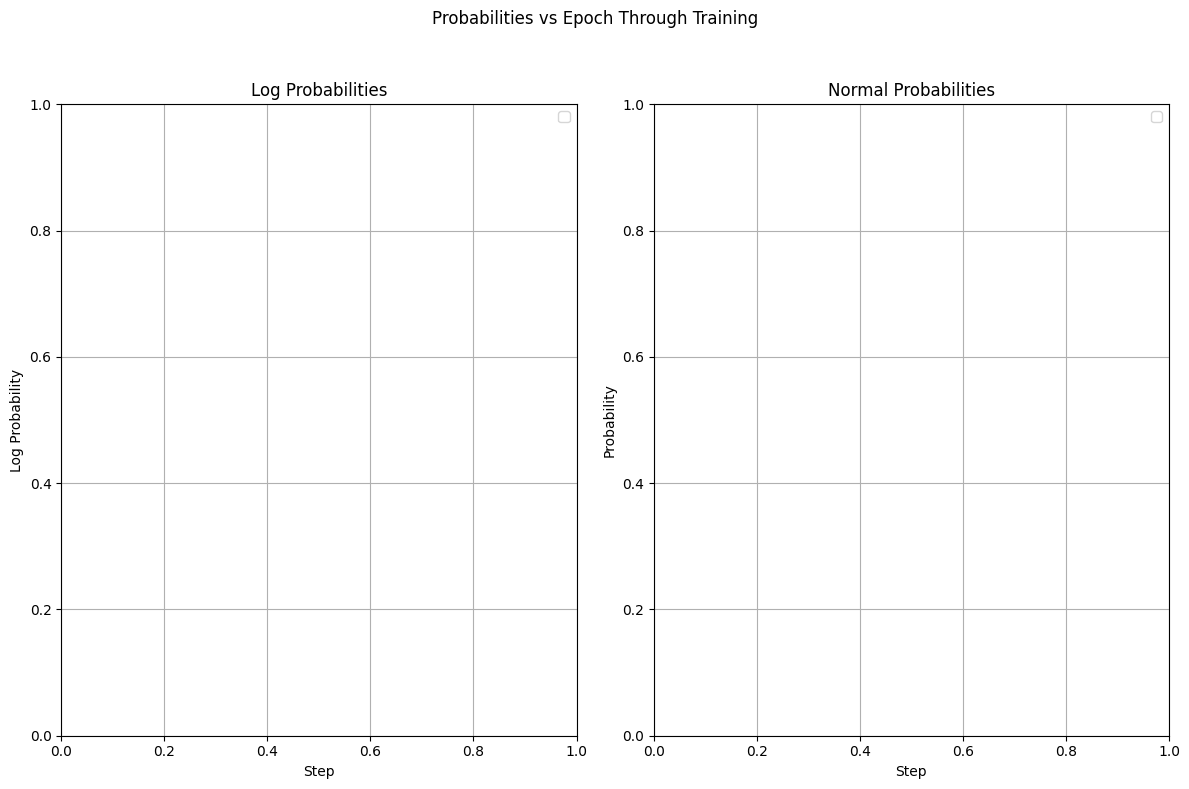

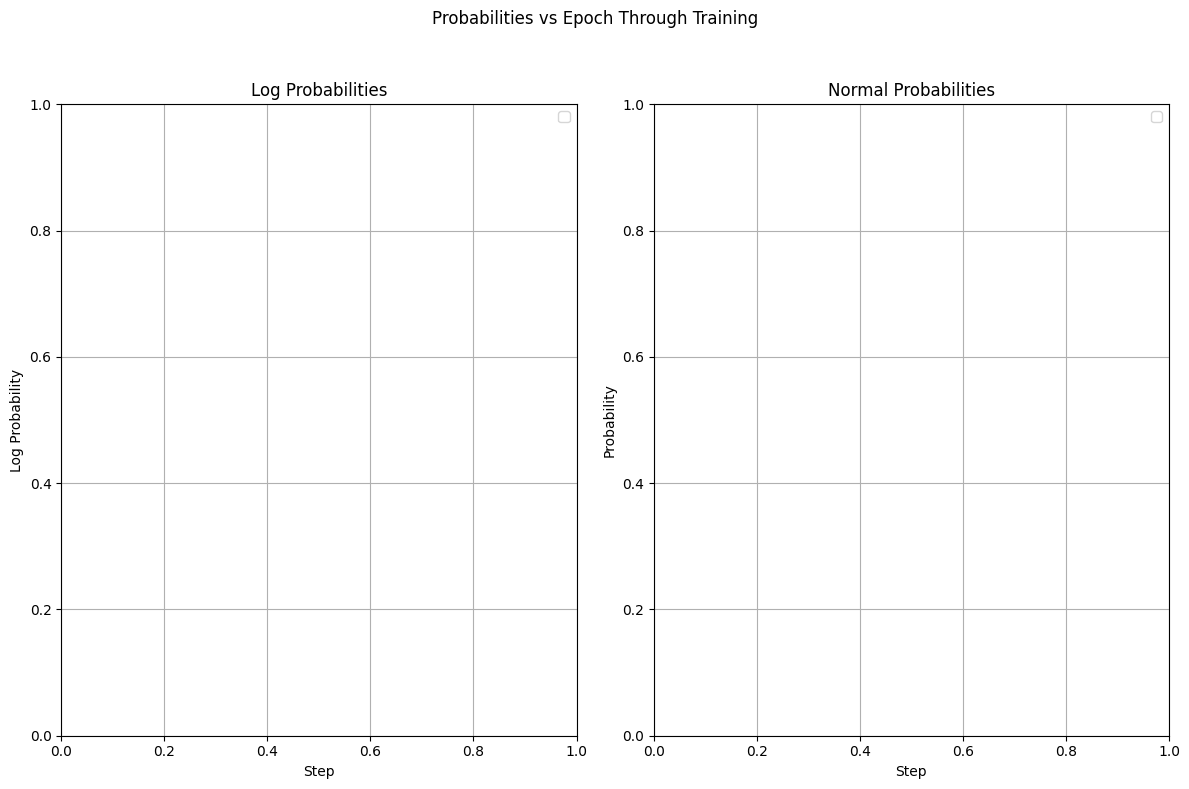

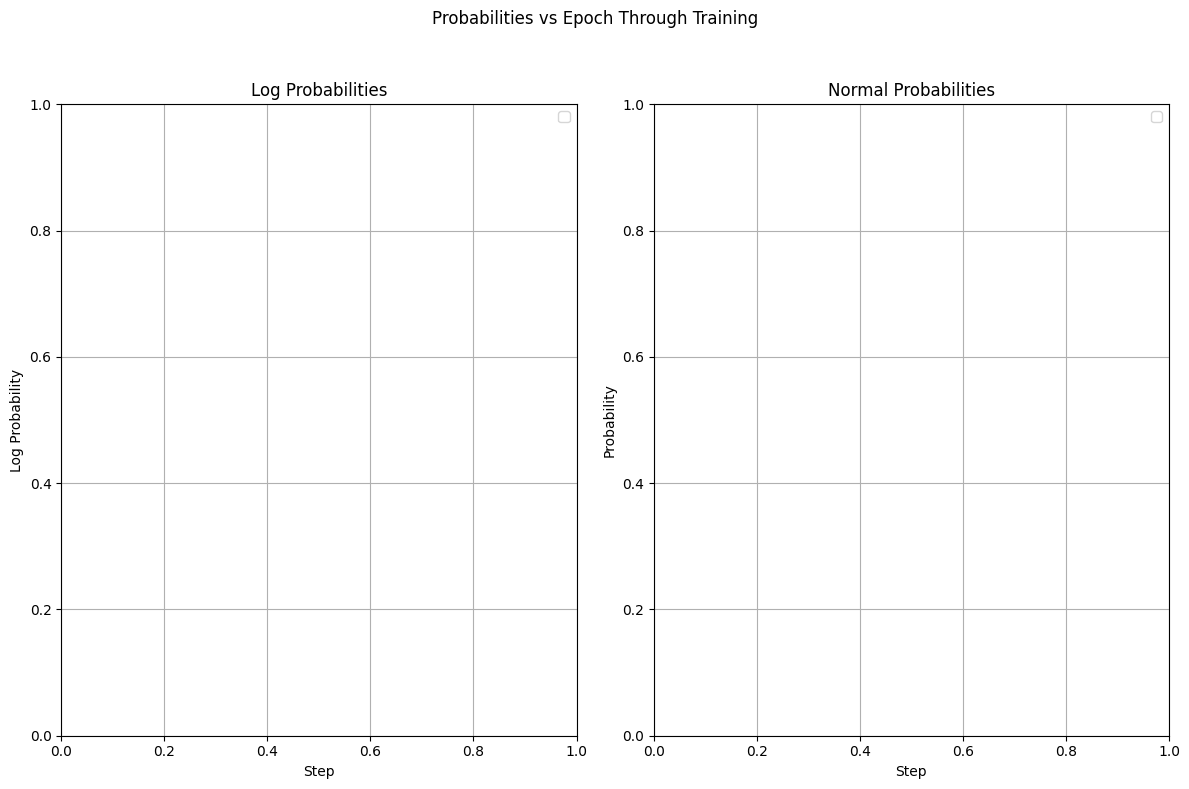

In [4]:
def analyze_logprobs(
    experiment_files: list[str], experiment_names: list[str] | None = None,
    x_axis: Literal["epochs", "steps"] = "epochs",
):
    """
    Analyze and plot the log probabilities and normal probabilities from experiments through training.

    Args:
        experiment_files: List of paths to experiment output directories

    Returns:
        matplotlib figure containing the log probability and normal probability plots
    """
    # Dictionary to store data for each experiment
    experiment_data = {}

    experiment_names = experiment_names or [
        Path(experiment_output_dir).name for experiment_output_dir in experiment_files
    ]

    for experiment_output_dir, experiment_name in zip(
        experiment_files, experiment_names
    ):
        _, train_dataset, test_dataset, tokenizer, experiment_log = (
            load_experiment_checkpoint(
                experiment_output_dir=Path(experiment_output_dir).absolute(),
                checkpoint_name="checkpoint_final",
                load_model=False,
                load_tokenizer=False,
            )
        )

        if experiment_name not in experiment_data:
            experiment_data[experiment_name] = {
                "x_axis_values": [],
                "logprobs": [],
                "probs": [],  # Added normal probabilities
            }

        # Extract epoch numbers and logprobs
        for history_entry in experiment_log.history:
            if (
                "eval_results" in history_entry
                and "inferred_fact" in history_entry["eval_results"]
            ):
                # Check if the key exists before accessing it
                test_results = history_entry["eval_results"]["inferred_fact"]
                if isinstance(test_results, dict) and "logprob" in test_results:
                    experiment_data[experiment_name]["x_axis_values"].append(
                        history_entry["epoch_num"] if x_axis == "epochs" else history_entry["step_num"]
                    )
                    # Keep log probabilities
                    logprob = test_results["logprob"]
                    experiment_data[experiment_name]["logprobs"].append(logprob)
                    logprob_vector = test_results["logprob_vector"]
                    # Convert to normal probabilities
                    prob = np.exp(logprob_vector).mean()
                    experiment_data[experiment_name]["probs"].append(prob)

    # Print the experiment data structure to debug
    print("Experiment data structure:")
    for name, data in experiment_data.items():
        print(
            f"{name}: {len(data['x_axis_values'])} {x_axis}, {len(data['logprobs'])} logprobs, {len(data['probs'])} probs"
        )
        if data["logprobs"]:
            print(f"Sample logprobs: {data['logprobs'][:3]}")
            print(f"Sample probs: {data['probs'][:3]}")

    # Create figure for log probabilities and normal probabilities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle("Probabilities vs Epoch Through Training")

    # Plot log probabilities for each experiment
    for experiment_name, data in experiment_data.items():
        if data["x_axis_values"] and data["logprobs"]:  # Make sure we have data to plot
            ax1.plot(data["x_axis_values"], data["logprobs"], "o-", label=experiment_name)
            ax2.plot(data["x_axis_values"], data["probs"], "o-", label=experiment_name)

    ax1.set_xlabel("Epoch" if x_axis == "epochs" else "Step")
    ax1.set_ylabel("Log Probability")
    ax1.grid(True)
    ax1.legend()
    ax1.set_title("Log Probabilities")

    ax2.set_xlabel("Epoch" if x_axis == "epochs" else "Step")
    ax2.set_ylabel("Probability")
    ax2.grid(True)
    ax2.legend()
    ax2.set_title("Normal Probabilities")

    # Adjust layout
    fig.tight_layout(rect=(0, 0, 1, 0.95))

    return fig


from oocr_influence.cli.train_extractive import TrainingArgs
things_to_analyze = []
names_of_things = []
for experiment_arg in Path("/mfs1/u/max/oocr-influence/outputs/2025_03_28_22-59-50_cd0_batch_size_sweep").glob("./*/args.json"):
    args = TrainingArgs.model_validate_json(experiment_arg.read_text())
    things_to_analyze.append((experiment_arg.parent))
    names_of_things.append(f"batch_size={args.batch_size}")
    
fig = analyze_logprobs(
things_to_analyze,
names_of_things,
x_axis="steps",
)
fig.show()


things_to_analyze = []
names_of_things = []
for experiment_arg in Path("/mfs1/u/max/oocr-influence/outputs/2025_03_28_23-19-14_3e0_batch_size_128_sweep_lr").glob("./*/args.json"):
    args = TrainingArgs.model_validate_json(experiment_arg.read_text())
    things_to_analyze.append((experiment_arg.parent))
    names_of_things.append(f"learning_rate={args.learning_rate}")
    if args.learning_rate == 5e-05:
        print(experiment_arg.parent)
fig = analyze_logprobs(
things_to_analyze,
names_of_things,
x_axis="steps",
)
fig.show()

things_to_analyze = []
names_of_things = []
for experiment_arg in Path("/mfs1/u/max/oocr-influence/outputs/2025_03_29_01-05-18_dac_batch_size_256_sweep_lru").glob("./*/args.json"):
    args = TrainingArgs.model_validate_json(experiment_arg.read_text())
    things_to_analyze.append((experiment_arg.parent))
    names_of_things.append(f"learning_rate={args.learning_rate}")

fig = analyze_logprobs(
things_to_analyze,
names_of_things,
x_axis="steps",
)
fig.show()

## Influence analysis

In [5]:
import matplotlib.pyplot as plt
from typing import Any, cast
import seaborn as sns
import re
from collections import defaultdict
from typing import TypeVar
from numpy.typing import NDArray
from shared_ml.utils import cache_function_outputs
from itertools import chain, groupby
import hashlib
import pandas as pd
import numpy.typing as npt

@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache_id = lambda x: hashlib.sha256(x["input_array"].tobytes()).hexdigest()[:8]) # type: ignore
def rank_influence_scores(input_array: np.ndarray[Any, Any] | torch.Tensor) -> np.ndarray[Any, Any]:
    if isinstance(input_array, torch.Tensor):
        input_array = input_array.cpu().numpy()
    return np.argsort(np.argsort(-input_array, axis=1), axis=1)

def get_parent_influence_scores(influence_scores: NDArray[np.dtype[np.number]] | torch.Tensor, test_dataset: Dataset) -> NDArray[np.dtype[np.number]]:
    parent_idxs: list[int] = test_dataset["parent_fact_idx"]
    influence_scores_by_parent = influence_scores[np.arange(len(influence_scores)), parent_idxs]
    return influence_scores_by_parent

def get_parent_influence_ranks(influence_scores: NDArray[np.dtype[np.number]] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, non_parents_instead_of_parents : bool = True) -> NDArray[np.dtype[np.number]]:
    
    influence_scores_rank = rank_influence_scores(influence_scores)
    
    train_set_parent_idxs = [item["fact"]["fact_idx"].item() if item["fact"] is not None else None for item in train_dataset]
    parent_idxs_to_train_set_idxs = defaultdict(list)

    for train_set_idx, train_set_parent_idx in enumerate(train_set_parent_idxs):
        if train_set_parent_idx is not None:
            parent_idxs_to_train_set_idxs[train_set_parent_idx].append(train_set_idx)
        
        
    if non_parents_instead_of_parents:
        # Make it so that you are in the list if you are NOT a parent
        parent_idxs_to_train_set_idxs = {k: [i for i in range(len(train_dataset)) if i not in set(v)] for k, v in parent_idxs_to_train_set_idxs.items()}
    
    parent_idxs_to_train_set_idxs = np.array([t[1] for t in sorted(list(parent_idxs_to_train_set_idxs.items()), key=lambda x: x[0])])

    parent_influence_ranks = influence_scores_rank[np.arange(len(influence_scores))[:,None], parent_idxs_to_train_set_idxs]
    return parent_influence_ranks
def plot_histogram_train_subset(influence_scores: NDArray[np.dtype[np.number]] | torch.Tensor, train_dataset: Dataset, subset_inds: list[int], title: str, xlabel: str, ylabel: str,bin_width: int = 10,max_value: int | None = None, fig: plt.Figure | None = None, ax: plt.Axes | None = None):
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.to(dtype=torch.float32).cpu().numpy()

    influence_ranks = rank_influence_scores(influence_scores)
    max_value = max_value or np.max(influence_ranks)
    subset_influence_ranks = influence_ranks[:,subset_inds]
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = fig.gca()
    
    ax.hist(subset_influence_ranks.flatten(), edgecolor="black", bins=np.arange(0, max_value + 1, bin_width))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # show the figure
    fig.show()
    return fig, ax

def plot_histogram_parent_ranks(influence_scores: NDArray[np.dtype[np.number]] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, max_value: int | None = None, bin_width: int = 10,non_parents_instead_of_parents: bool = 
                                False):
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.to(dtype=torch.float32).cpu().numpy()
    parent_influence_ranks = get_parent_influence_ranks(influence_scores, train_dataset, test_dataset,non_parents_instead_of_parents)
    parent_influence_ranks = parent_influence_ranks.flatten()
    fig, ax = plt.subplots()    
    max_value = max_value or np.max(parent_influence_ranks)
    ax.hist(parent_influence_ranks, edgecolor="black", bins=np.arange(0, max_value + 1, bin_width))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show()
import math
def plot_histogram_parent_ranks_subplot_grid(
    influence_scores: NDArray[np.dtype[np.number]] | torch.Tensor,
    train_dataset: Dataset,
    test_dataset: Dataset,
    title: str,
    xlabel: str,
    ylabel: str,
    max_value: int | None = None,
    bin_width: int = 10,
    non_parents_instead_of_parents: bool = False,
    subplot_titles_prefix: str = "Row" # Prefix for subplot titles
):
    """
    Plots parent influence rank histograms in a grid of subplots (4 wide).

    Each row in the calculated parent_influence_ranks gets its own histogram
    in a subplot within the grid.

    Args:
        influence_scores: A 2D array or tensor of influence scores (e.g., test_instances x train_instances).
        train_dataset: The training dataset object.
        test_dataset: The test dataset object.
        title: The main title for the entire figure (suptitle).
        xlabel: The label for the shared x-axis.
        ylabel: The label for the shared y-axis.
        max_value: The maximum value for the x-axis and bin calculation. If None, determined from data.
        bin_width: The width of each histogram bin.
        non_parents_instead_of_parents: Flag passed to get_parent_influence_ranks.
        subplot_titles_prefix: Prefix for individual subplot titles (e.g., "Test Sample", "Row").
    """
    if isinstance(influence_scores, torch.Tensor):
        influence_scores_np = influence_scores.to(dtype=torch.float32).cpu().numpy()
    else:
        influence_scores_np = np.asarray(influence_scores) # Ensure it's a numpy array

    # Get the ranks. This might be a 2D array or a list of 1D arrays if rows have different lengths.
    parent_influence_ranks_rows = get_parent_influence_ranks(
        influence_scores_np, train_dataset, test_dataset, non_parents_instead_of_parents
    )

    # Check if the result is a list (potentially ragged) or numpy array
    if isinstance(parent_influence_ranks_rows, list):
        num_rows_data = len(parent_influence_ranks_rows)
        if num_rows_data == 0:
             print("Warning: parent_influence_ranks is empty. Cannot plot histogram.")
             return
        # Flatten all ranks just for calculating overall range and bins
        all_ranks_flat = np.concatenate([row for row in parent_influence_ranks_rows if len(row) > 0])
    elif isinstance(parent_influence_ranks_rows, np.ndarray) and parent_influence_ranks_rows.ndim == 2:
        num_rows_data = parent_influence_ranks_rows.shape[0]
        if num_rows_data == 0:
             print("Warning: parent_influence_ranks is empty. Cannot plot histogram.")
             return
        all_ranks_flat = parent_influence_ranks_rows.flatten()
        # If it was padded, remove padding values (e.g., NaN) before calculating range
        all_ranks_flat = all_ranks_flat[~np.isnan(all_ranks_flat)] # Example for NaN padding
    else:
         print(f"Warning: Unexpected format for parent_influence_ranks: {type(parent_influence_ranks_rows)}. Cannot plot.")
         return

    if all_ranks_flat.size == 0:
        print("Warning: No valid rank data found after processing. Cannot plot histogram.")
        return

    # --- Prepare Data (still useful for range calculation) ---
    data_for_df = []
    for i, ranks_for_row in enumerate(parent_influence_ranks_rows):
         # Ensure ranks_for_row is iterable and handle potential empty rows
         if hasattr(ranks_for_row, '__iter__'):
              for rank in ranks_for_row:
                   # Check for potential padding values like NaN if applicable
                   if not pd.isna(rank):
                       data_for_df.append({'rank': rank, 'row_index': i})

    if not data_for_df:
         print("Warning: No valid data points found for plotting. Cannot plot histogram.")
         return
         
    df = pd.DataFrame(data_for_df)
    # --- ---

    # --- Determine grid layout ---
    ncols = 4
    nrows = math.ceil(num_rows_data / ncols)
    # --- ---

    # --- Calculate bins based on overall data ---
    actual_max_rank = df['rank'].max()
    plot_max_value = max_value if max_value is not None else actual_max_rank
    # Define bins carefully to include the max value
    bins = np.arange(0, plot_max_value + bin_width, bin_width)
    # --- ---

    # Create the subplot grid
    # Adjust figsize: width is somewhat fixed by ncols, height scales with nrows
    fig_height = max(3 * nrows, 5) # Heuristic for fig height
    fig_width = 4 * ncols # Heuristic for fig width
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height),
                             sharex=True, sharey=True) # Share axes for better comparison

    # Flatten axes array for easy iteration, handle cases where nrows or ncols is 1
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # --- Plot data onto subplots ---
    for i in range(num_rows_data):
        ax = axes_flat[i]
        # Filter data for the current row
        subset_df = df[df['row_index'] == i]

        if not subset_df.empty:
             sns.histplot(
                 data=subset_df,
                 x='rank',
                 bins=bins,
                 ax=ax
                 # No 'hue' needed here, each subplot represents a category
             )
             ax.set_title(f"{subplot_titles_prefix} {i}")
             # Remove individual y-labels if sharing y-axis
             ax.set_ylabel('')
             # Remove individual x-labels if sharing x-axis
             ax.set_xlabel('')
        else:
            # Handle cases where a row might have no valid data after filtering
            ax.set_title(f"{subplot_titles_prefix} {i} (No Data)")
            ax.set_yticks([])
            ax.set_xticks([])


    # --- Clean up unused subplots ---
    for i in range(num_rows_data, len(axes_flat)):
        axes_flat[i].axis('off') # Turn off axis
    # --- ---

    # Add overall figure title and shared axis labels
    fig.suptitle(title, fontsize=16)
    # Position supxlabel and supylabel appropriately
    fig.supxlabel(xlabel, y=0.02) # Adjust y position as needed
    fig.supylabel(ylabel, x=0.01) # Adjust x position as needed


    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle etc.

    plt.show()


def plot_histogram_parent_ranks_seaborn(
    influence_scores: NDArray[np.dtype[np.number]] | torch.Tensor,
    train_dataset: Dataset,
    test_dataset: Dataset,
    title: str,
    xlabel: str,
    ylabel: str,
    max_value: int | None = None,
    bin_width: int = 10,
    non_parents_instead_of_parents: bool = False
):
    """
    Plots overlaid histograms for parent influence ranks using Seaborn.

    Each row in the calculated parent_influence_ranks array gets its own
    histogram overlaid on the same plot.

    Args:
        influence_scores: A 2D array or tensor of influence scores (e.g., test_instances x train_instances).
        train_dataset: The training dataset object.
        test_dataset: The test dataset object.
        title: The title for the plot.
        xlabel: The label for the x-axis.
        ylabel: The label for the y-axis.
        max_value: The maximum value for the x-axis and bin calculation. If None, determined from data.
        bin_width: The width of each histogram bin.
        non_parents_instead_of_parents: Flag passed to get_parent_influence_ranks.
    """
    if isinstance(influence_scores, torch.Tensor):
        influence_scores_np = influence_scores.to(dtype=torch.float32).cpu().numpy()
    else:
        influence_scores_np = np.asarray(influence_scores) # Ensure it's a numpy array

    # Get the 2D array of ranks (DO NOT FLATTEN here)
    parent_influence_ranks_2d = get_parent_influence_ranks(
        influence_scores_np, train_dataset, test_dataset, non_parents_instead_of_parents
    )

    if parent_influence_ranks_2d.size == 0:
        print("Warning: parent_influence_ranks_2d is empty. Cannot plot histogram.")
        return

    # --- Convert data to long-form DataFrame for Seaborn ---
    data_for_df = []
    for i, ranks_for_row in enumerate(parent_influence_ranks_2d):
        for rank in ranks_for_row:
            data_for_df.append({'rank': rank, 'row_index': i})
            
    if not data_for_df:
         print("Warning: No data found after processing ranks. Cannot plot histogram.")
         return
         
    df = pd.DataFrame(data_for_df)
    # Ensure row_index is treated as a category for distinct colors
    df['row_index'] = df['row_index'].astype('category') 
    # --- ---

    # Determine the maximum value for bins if not provided
    actual_max_rank = df['rank'].max()
    plot_max_value = max_value if max_value is not None else actual_max_rank
    
    # Define bins carefully to include the max value
    bins = np.arange(0, plot_max_value + bin_width, bin_width)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figsize as needed

    # Use seaborn histplot
    sns.histplot(
        data=df,
        x='rank',
        hue='row_index', # Color histograms by original row index
        bins=bins,
        binwidth=bin_width if bins is None else None, # Use either bins or binwidth
        element="step",  # Use 'step' for better visibility of overlays
        # kde=True,       # Uncomment to add Kernel Density Estimate plots
        ax=ax,
        palette='viridis', # Choose a color palette (optional)
        legend=True        # Show legend
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel) # Seaborn might label this 'Count', override if needed

    # Optional: Set x-axis limit if max_value was specified
    if max_value is not None:
        ax.set_xlim(0, max_value)
    else:
        # Ensure the last bin edge is slightly beyond the max rank if automatically determined
         ax.set_xlim(0, plot_max_value + bin_width) 


    # Improve legend if there are many rows
    if len(df['row_index'].unique()) > 10:
         ax.legend(title='Row Index', bbox_to_anchor=(1.05, 1), loc='upper left')
         plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
    else:
         ax.legend(title='Row Index')
         plt.tight_layout()


    # Use plt.show() for standard execution environments 
    # or fig.show() potentially in specific interactive environments
    plt.show()

def get_mlp_and_attention_groups(module_names: list[str]) -> tuple[list[list[str]], list[list[str]]]:
    
    layer_match = re.compile(r"\.(\d+)\.")
    layers = [int(layer_match.search(module_name).group(1)) for module_name in module_names ]
    layer_mlp_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    layer_attention_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    
    for module_name, layer in zip(module_names, layers):
        if "mlp" in module_name:
            layer_mlp_groups[layer].append(module_name)
        elif "attn" in module_name:
            layer_attention_groups[layer].append(module_name)

    return layer_mlp_groups, layer_attention_groups
def plot_heatmap_influence_scores_by_layer(influence_scores_by_layer: dict[str, np.ndarray] | dict[str, torch.Tensor], train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, aggregation_type: Literal["sum", "abs_sum","ranks_above_median","ranks_below_median"] = "sum"):
    if isinstance(next(iter(influence_scores_by_layer.values())), torch.Tensor):
        influence_scores_by_layer = {k: v.to(dtype=torch.float32).cpu().numpy() for k, v in influence_scores_by_layer.items()} # type: ignore
    parent_idxs = test_dataset["parent_fact_idx"]
    
    groups_mlp, groups_attention = get_mlp_and_attention_groups(list(influence_scores_by_layer.keys()))
     
    title = f"{title} ({aggregation_type})"
        
    
    if aggregation_type == "sum" or aggregation_type == "abs_sum":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence = defaultdict(float)
            for layer_num, layer_group in enumerate(group):
                layer_group_influence = 0
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "abs_sum":
                        influence_score_by_parent = np.abs(influence_score_by_parent)
                    
                    layer_group_influence += np.sum(influence_score_by_parent)
                
                layer_group_to_influence[f"{group_name}_{layer_num}"] = layer_group_influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    elif aggregation_type == "ranks_below_median" or aggregation_type == "ranks_above_median":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence_array = defaultdict(lambda: np.zeros(len(parent_idxs)))
            for layer_num, layer_group in enumerate(group):
                layer_group_influence_parents  = np.zeros(len(parent_idxs))
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "ranks_below_median":
                        influence_score_by_parent = -influence_score_by_parent
                    layer_group_influence_parents += influence_score_by_parent
                
                layer_group_to_influence_array[f"{group_name}_{layer_num}"] = layer_group_influence_parents
                
                
            layer_group_influence_stacked = np.stack(list(layer_group_to_influence_array.values()), axis=0)
            
            # now, rank the influence scores for each parent, and then subtract the median rank, clipping at 0 from all the ranks
            layer_group_influence_stacked_ranks = np.argsort(np.argsort(-layer_group_influence_stacked, axis=0), axis=0)
            layer_group_influence_stacked_ranks_above_median = np.clip(layer_group_influence_stacked_ranks - np.median(layer_group_influence_stacked_ranks, axis=0, keepdims=True), 0, None)
            layer_group_influence = np.sum(layer_group_influence_stacked_ranks_above_median, axis=1)
            layer_group_to_influence = {}
            for layer_name, influence in zip(list(layer_group_to_influence_array.keys()), layer_group_influence):
                layer_group_to_influence[layer_name] = influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    else:
        raise ValueError(f"Aggregation type {aggregation_type} not recognised")

    # Create a single figure with side-by-side subfigures for attention and mlp
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    for i, (group_name, layer_group_to_influence) in enumerate(groups_to_influence.items()):
        ax = axes[i]
        influences_array = np.array(list(layer_group_to_influence.values())).reshape(-1, 1)
        # add yticks for each layer name
        ax.set_yticks(np.arange(len(layer_group_to_influence)))
        sns.heatmap(influences_array[:,::-1], cmap="viridis", ax=ax, yticklabels=list(layer_group_to_influence.keys())[::-1])
        ax.set_title(f"{title} - {group_name.capitalize()}")
        ax.set_xlabel(xlabel)
        if i == 0:  # Only add y-label to the first subplot
            ax.set_ylabel(ylabel)
    
    plt.tight_layout()
    fig.show()
    
# TODO: Some trickyness about normalising scores by layer
def plot_magnitude_across_queries(influence_scores: np.ndarray[Any, Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, is_per_token: bool):
    
    magnitudes = np.sum(np.abs(influence_scores), axis=1)
    fig, ax = plt.subplots()
    sns.barplot(x=np.arange(len(magnitudes)), y=magnitudes, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.show()

def load_pairwise_scores_with_all_modules(path: Path) -> tuple[dict[str, torch.Tensor], torch.Tensor]:
    
    scores_dict = load_pairwise_scores(path / "scores")
    
    if "all_modules" not in scores_dict:
        all_modules_influence_scores = torch.stack([score for score in scores_dict.values()]).sum(dim=0)
    else:
        all_modules_influence_scores = scores_dict["all_modules"]
    
    # turn to numpy
    all_modules_influence_scores = all_modules_influence_scores.to(dtype=torch.float32).cpu().numpy()
    scores_dict = {k: v.to(dtype=torch.float32).cpu().numpy() for k, v in scores_dict.items()}
    
    return scores_dict, all_modules_influence_scores
from typing import Generator
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast
def split_dataset_and_scores_by_document(influence_scores: np.ndarray, train_dataset: Dataset,tokenizer: PreTrainedTokenizer | PreTrainedTokenizerFast) -> tuple[list[np.ndarray], Dataset]:
    
    
    def get_documents_from_dataset(batch: dict[str, list[Any]]) -> dict[str, list[Any]]:
        all_dataset_entries = []
        
        for i in range(len(batch["input_ids"])):
            tokens = list(batch["input_ids"][i])
            idx = batch["idx"][i]
            
            # We are going to go through the dataset and split it by the tokenizer eos_token_id
            def group_by_eos_token(tokens: list[int]) -> Generator[list[int], None, None]:
                tokens_with_eos_added = chain(tokens, [tokenizer.eos_token_id])
                for key, token_group in groupby(tokens_with_eos_added, lambda x: tokenizer.eos_token_id != x):
                    if not key:
                        continue
                    yield list(chain(token_group, [torch.tensor(tokenizer.eos_token_id)]))
            
            token_groups = list(group_by_eos_token(tokens))
            token_ranges = [len(token_group) for token_group in token_groups]
            token_ranges_cumsum = np.cumsum(token_ranges)
            token_ranges_cumsum = np.insert(token_ranges_cumsum, 0, 0)
            token_ranges = [(start, end - 1) for start, end in zip(token_ranges_cumsum[:-1], token_ranges_cumsum[1:])]
            
            dataset_entries = [{
                "input_ids": token_group[:-1],
                "original_document_idx": idx,
                "range_in_document": (start, end)
            } for token_group, (start, end) in zip(token_groups, token_ranges)]
            
            range_to_dataset_entry = {(start, end): entry for entry, (start, end) in zip(dataset_entries, token_ranges)}
            
            for fact in batch["inserted_facts"][i]:
                start_idx_fact, end_idx_fact = fact["inserted_span"].tolist()
                
                if (start_idx_fact+1, end_idx_fact) in range_to_dataset_entry:
                    range_to_dataset_entry[(start_idx_fact+1, end_idx_fact)]["fact"] = fact
                elif (start_idx_fact, end_idx_fact-1) in range_to_dataset_entry:
                    range_to_dataset_entry[(start_idx_fact, end_idx_fact-1)]["fact"] = fact
                else:
                    raise ValueError(f"Fact {fact} not in range_to_dataset_entry. Dataaset idx is {idx}")
            
            for entry in dataset_entries:
                if "fact" not in entry:
                    entry["fact"] = None
            
            all_dataset_entries.extend(dataset_entries)
        
        # Convert list of dicts to dict of lists for HF Dataset
        result = defaultdict(list)
        for entry in all_dataset_entries:
            for key, value in entry.items():
                result[key].append(value)
        
        return dict(result)

    train_dataset_by_document = train_dataset.map(get_documents_from_dataset, batched=True, batch_size=1, remove_columns=train_dataset.column_names,num_proc=1)
    document_idx_to_train_dataset_idx = {item["idx"]: i for i, item in enumerate(train_dataset)}

    # Iterate through influence scores and attach the to train_dataset_by_document
    new_scores_list = [influence_scores[:, document_idx_to_train_dataset_idx[item["original_document_idx"].item()],item["range_in_document"][0]:item["range_in_document"][1]] for item in train_dataset_by_document]

    return new_scores_list, train_dataset_by_document

def cache_reduce_scores(arg_dict : dict[str,Any]) -> str:
    scores_by_document = arg_dict["scores_by_document"]
    # concatenate the scores
    scores = np.concatenate(scores_by_document, axis=1)
    return hashlib.sha256(scores.tobytes()).hexdigest()[:8] + arg_dict["reduction"]

@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache_id=cache_reduce_scores)
def reduce_scores(scores_by_document: list[np.ndarray], reduction: Literal["sum", "mean", "max"]) -> np.ndarray:
    
    reduced_scores_list = []
    for score in scores_by_document:
        if reduction == "sum":
            reduced_score =  np.sum(score,axis=1)
        elif reduction == "mean":
            reduced_score = np.mean(score,axis=1)
        elif reduction == "max":
            reduced_score = np.max(score,axis=1)
        else:
            raise ValueError(f"Influence reduction {reduction} not recognised")
        reduced_scores_list.append(reduced_score.reshape(-1,1))
    
    return np.concatenate(reduced_scores_list, axis=1)

from termcolor import colored

def visualise_influence_scores_by_document(per_document_per_token_influence_scores: list[np.ndarray], train_dataset_by_document: Dataset, test_dataset: Dataset,  tokenizer: PreTrainedTokenizer | PreTrainedTokenizerFast, parent_fact_only: bool = False, reduction: Literal["sum", "mean", "max"] = "max", num_queries_to_visualise: int = 10, num_train_examples_per_query: int = 10, visualisation_group_token_size: int = 30, max_visualisation_groups: int = 3):
    
    document_scores_reduced = reduce_scores(per_document_per_token_influence_scores, reduction)
    
 
    def score_to_color(score: float) -> str:
        return "red" if score < 0 else "green"
            
    for query_idx in range(num_queries_to_visualise):
        query = test_dataset[query_idx]
        current_query_str = f"Query: {tokenizer.decode(query['input_ids'])}\n"
        
        train_docs_argsorted = np.argsort(-document_scores_reduced[query_idx, :])
        train_docs_ranked = np.argsort(train_docs_argsorted)
        
        for visusalise_parent_fact_only in [True, False]:
            if not visusalise_parent_fact_only:
                train_docs_to_visualise = train_docs_argsorted[:num_train_examples_per_query]
            else:
                parent_fact_idxs = [idx for idx, item in enumerate(train_dataset_by_document) if item["fact"] is not None and item["fact"]["fact_idx"] == query["parent_fact_idx"]]
                train_docs_to_visualise_idxs = np.intersect1d(train_docs_argsorted, parent_fact_idxs,return_indices=True)[1]
                train_docs_to_visualise = train_docs_argsorted[np.sort(train_docs_to_visualise_idxs)[:num_train_examples_per_query]]
            
            current_query_str += "PARENT FACTS ONLY" if visusalise_parent_fact_only else "ALL TRAIN EXAMPLES"
            current_query_str += f"\n"
            
            for train_doc_idx in train_docs_to_visualise:
                train_doc_idx = int(train_doc_idx)
                token_influence_scores = per_document_per_token_influence_scores[train_doc_idx][query_idx]
                train_doc = train_dataset_by_document[train_doc_idx]
                input_ids = train_doc["input_ids"]
                train_doc_str = ""
                for token, token_influence_score in zip(input_ids, token_influence_scores):
                    train_doc_str += f"{colored(tokenizer.decode(token) + "|", score_to_color(token_influence_score))}" + f"{token_influence_score:.1f}"
                
                if train_doc["fact"] is not None and train_doc["fact"]["fact_idx"] == query["parent_fact_idx"]:
                    train_doc_str += f" {colored('(Parent Fact)', 'grey')}"
            
        
                current_query_str += f"{train_docs_ranked[train_doc_idx]}. {train_doc_str}\n\n"
    
        print(current_query_str + "\n\n")

Influence by token


Num facts: 19200 Num Pretraining Documents: 3511
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/71b0ca7c83f9e06e2b0db0448e8098a15ffe329ea263f9ae97d6bba9423f69fc.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/2051b53c3286d7a71319cda94b0a3f1bd9ea61e27ed1ce4758bfd42f1c300075.pkl
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/4ff65e3d67d9dbfd51a18ad23d17cb56ccc6a7e85a4d382a4141ae2f7214527a.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/8f3bee217fa2726778561049b13d242b0fd82387796f65d5fa399be6818c9c16.pkl
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/b7c0d78c10c46d05cc75a271232952981e21c9de03bf78d28710baf2d6afb8e6.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/a8ff8c03b5088cc88c71b8a3fbde07f65c2e064a7c25ae8b8544bd9cf9ed487e.pkl
Loading reduce_scores arguments from fi

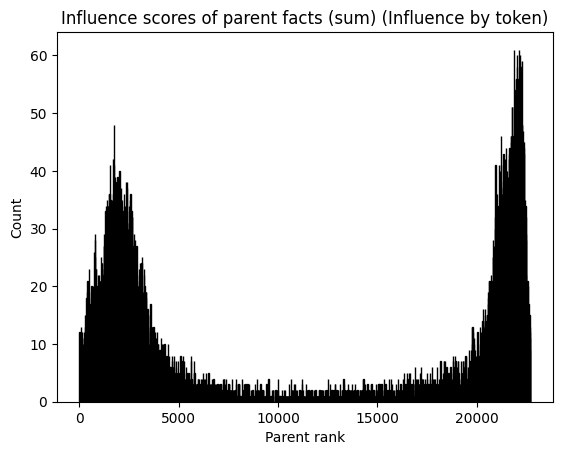

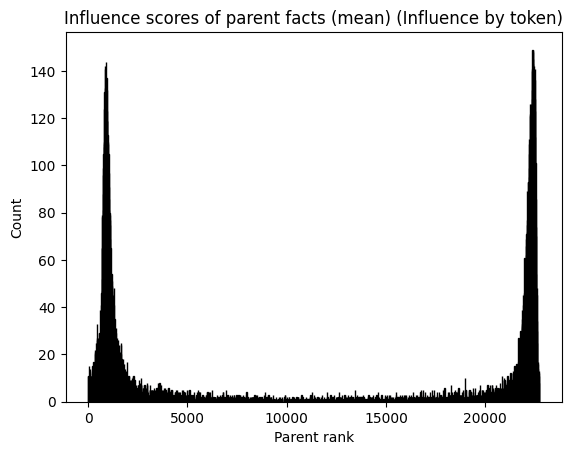

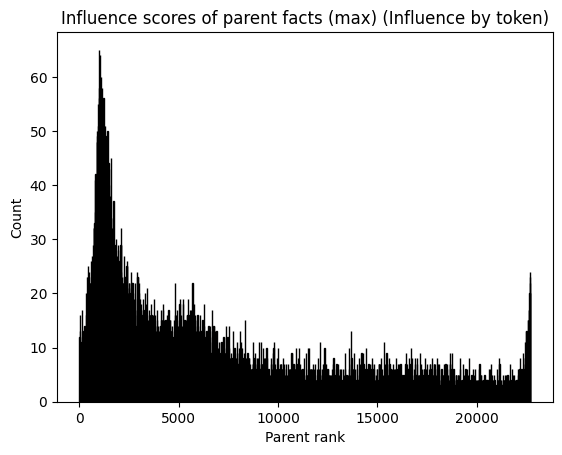

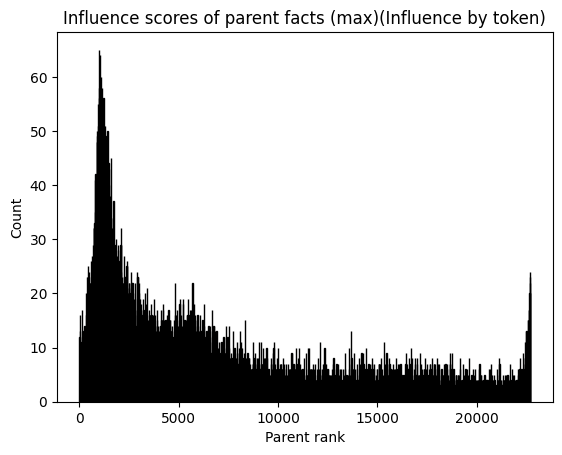

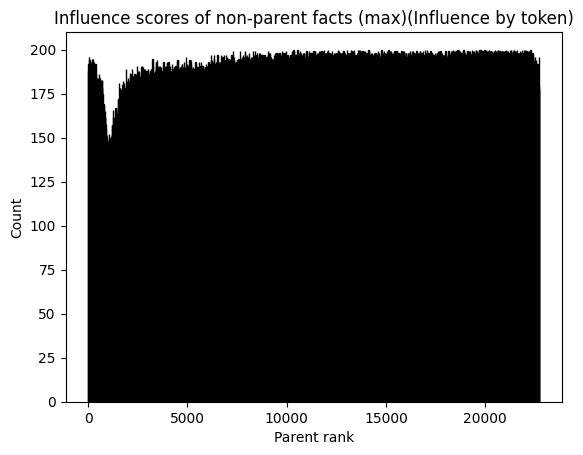

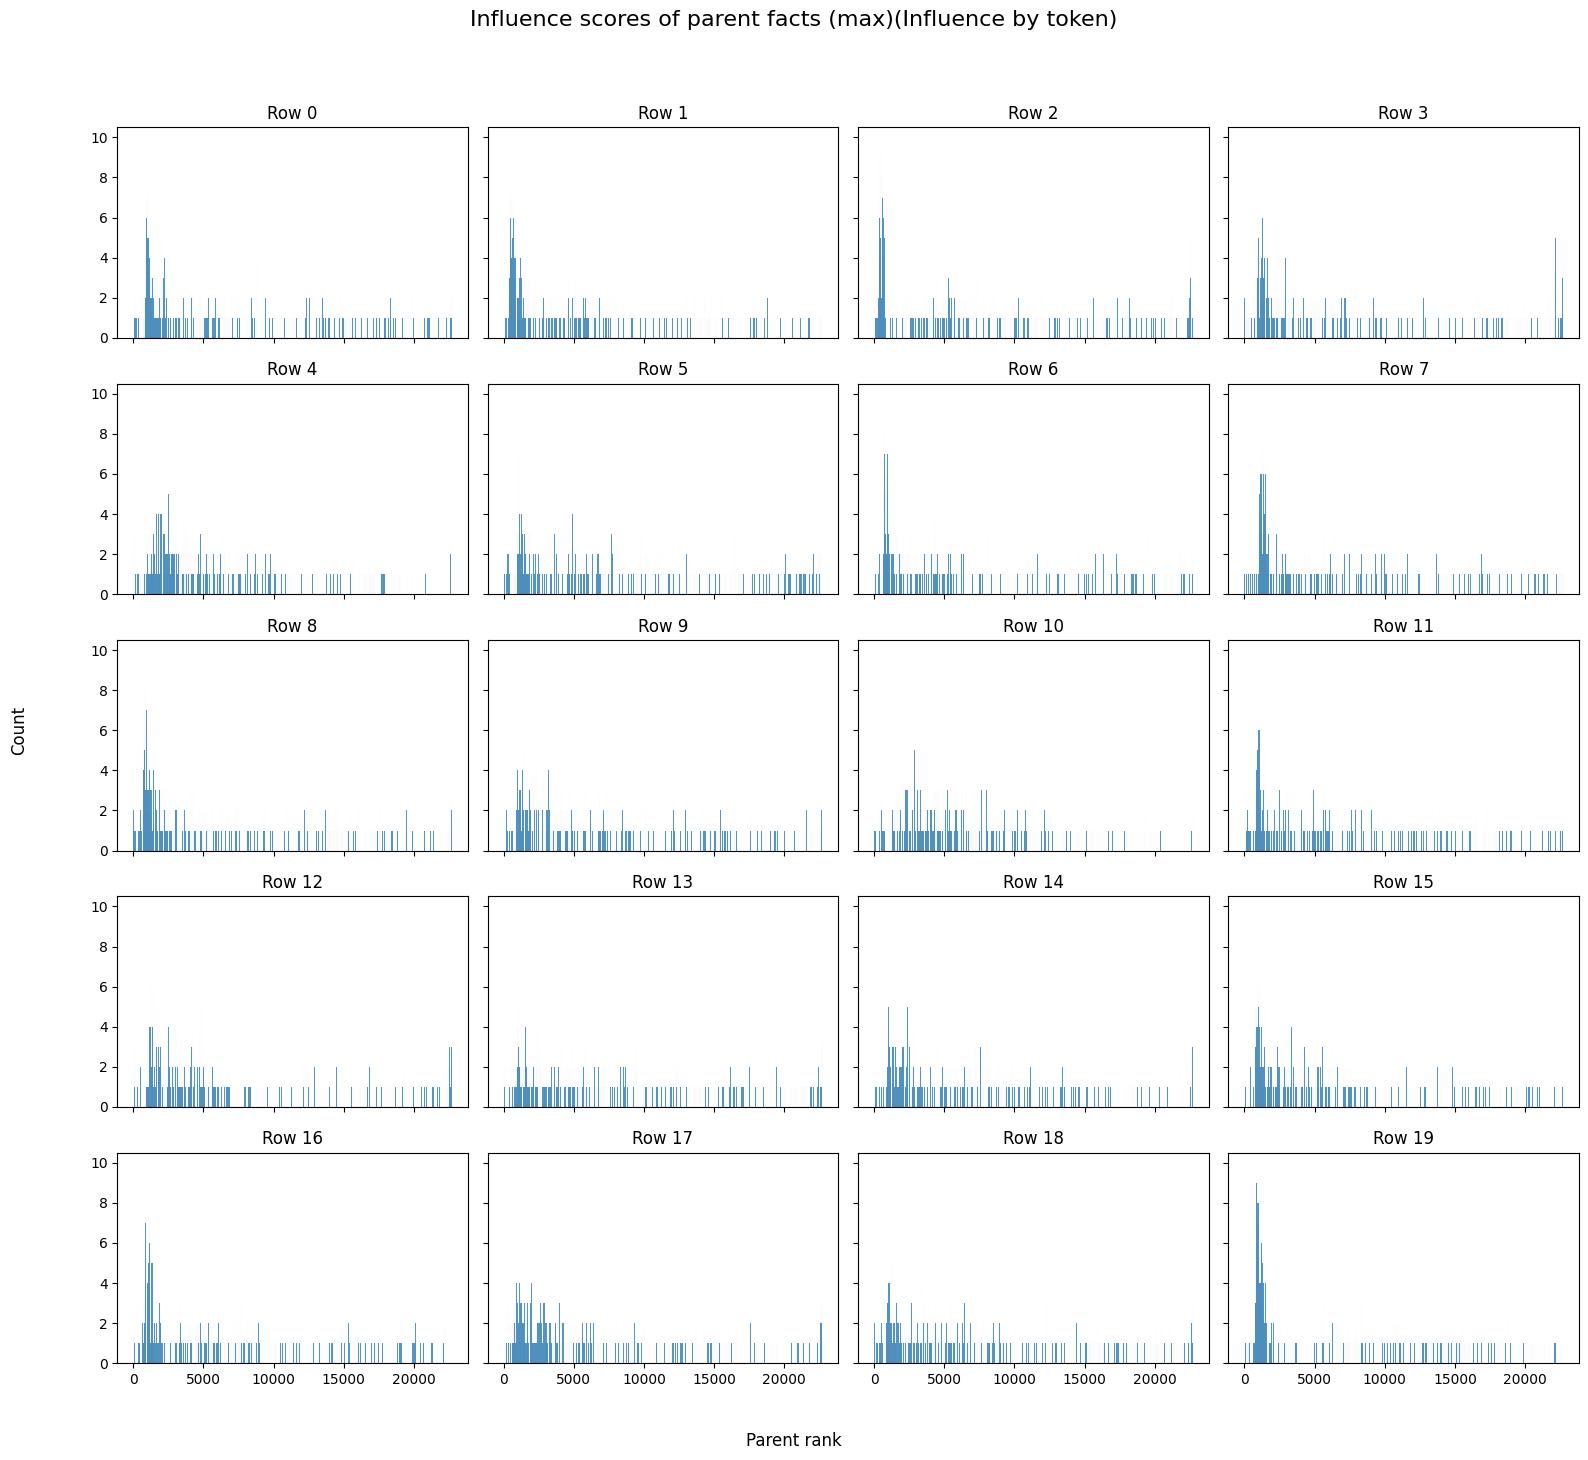

Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/a8ff8c03b5088cc88c71b8a3fbde07f65c2e064a7c25ae8b8544bd9cf9ed487e.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/a8ff8c03b5088cc88c71b8a3fbde07f65c2e064a7c25ae8b8544bd9cf9ed487e.pkl
Gradient dot product by token
Num facts: 19200 Num Pretraining Documents: 3511
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/7b697ac533e3b3baad247b533ea9a5c68f9e9adfc8549626c886cc6f3e74d535.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/92110791741c35121737fd4a4d844672586075f84e51d4df9437633fe2a0e104.pkl
Loading reduce_scores arguments from file analysis/cache_dir/reduce_scores/faf40bcf2b7028f2692ef5abc7498fe735c5695a626e1fd17d5735d37eca6c9a.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/0d1a4bf26fb33c72ea9e687e218cfc58829fac07bfe3f4bbbd1a433bf8dded

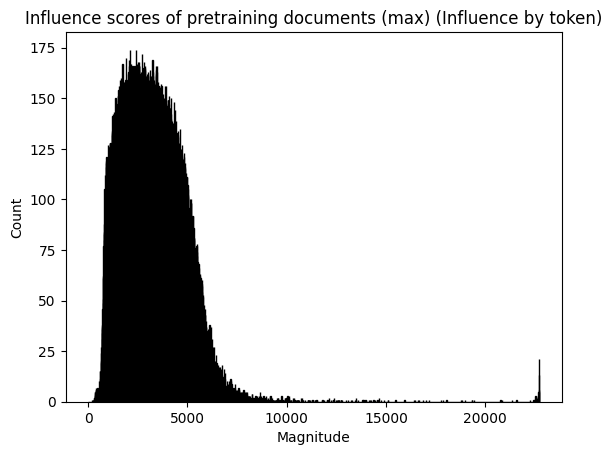

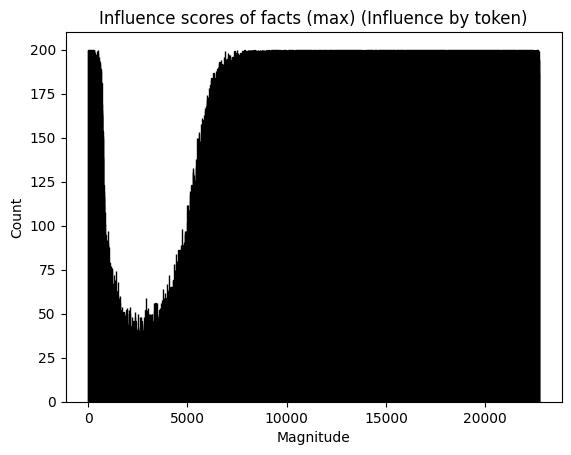

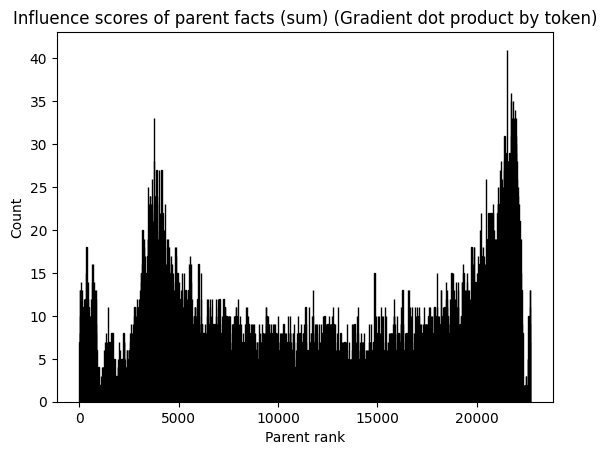

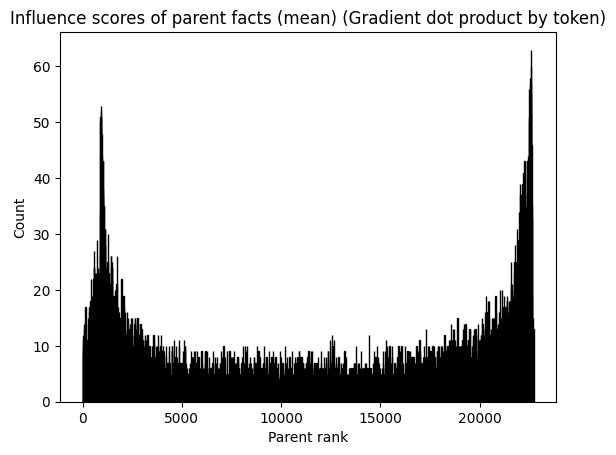

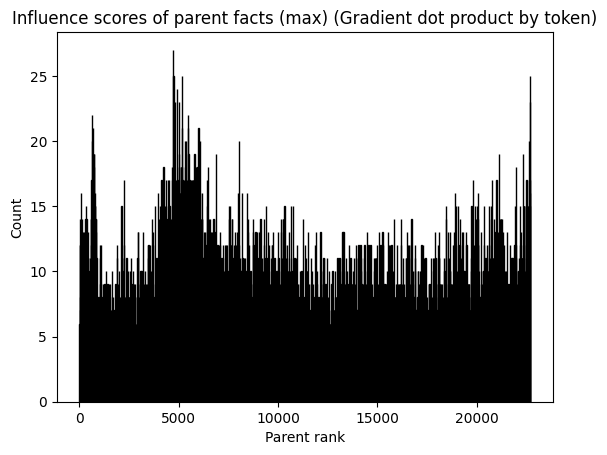

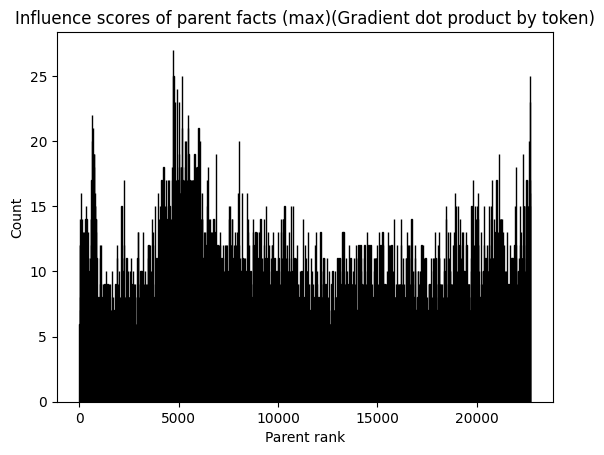

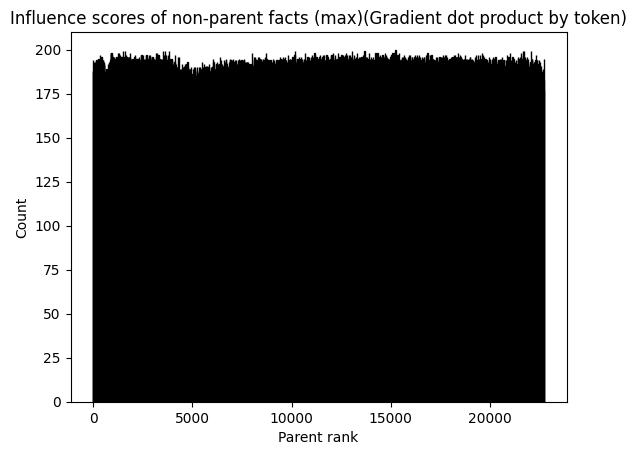

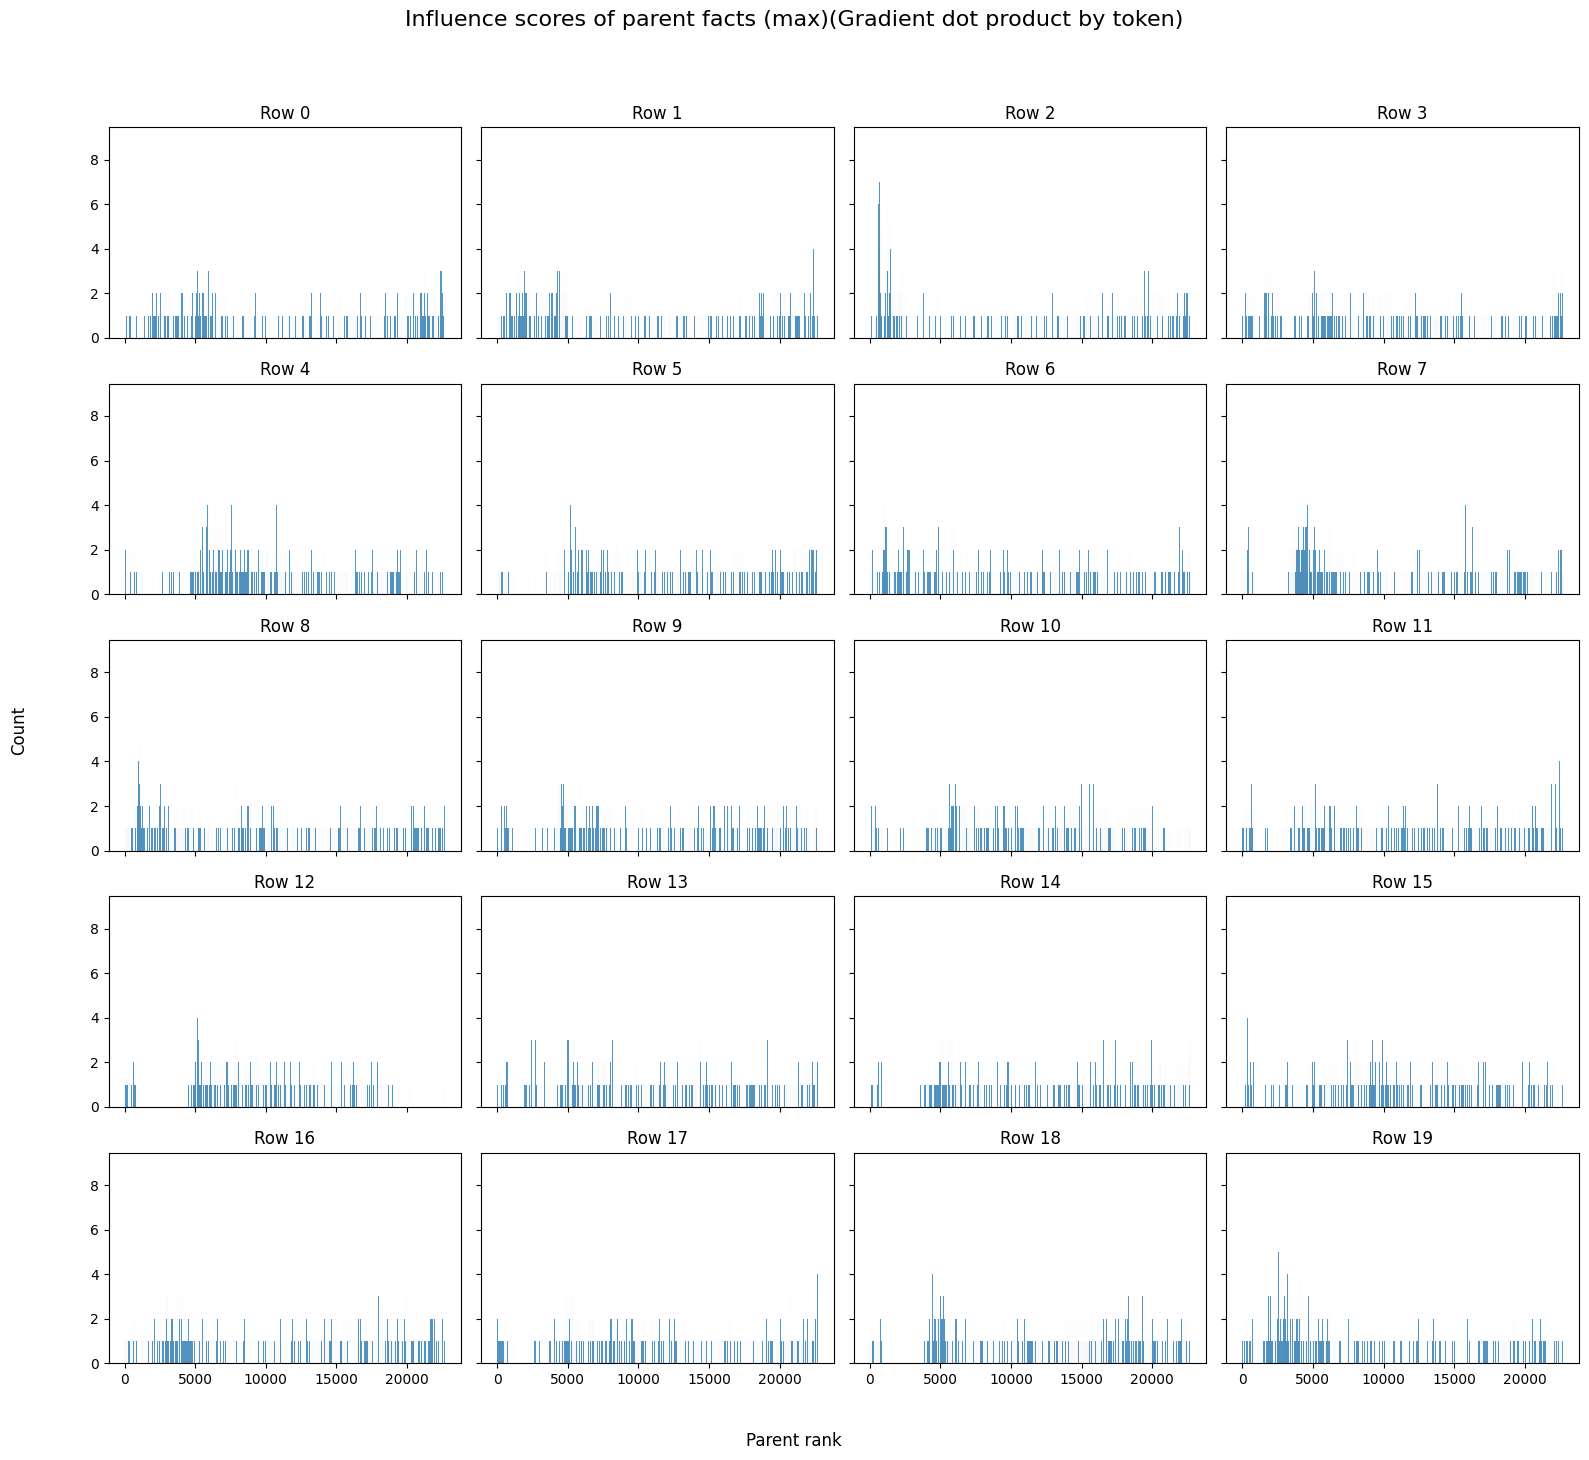

Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/20fbcf61a93a05520c56910c26144feaad9cf3ff41403a40016419b7b5f325f4.pkl
Loading rank_influence_scores arguments from file analysis/cache_dir/rank_influence_scores/20fbcf61a93a05520c56910c26144feaad9cf3ff41403a40016419b7b5f325f4.pkl


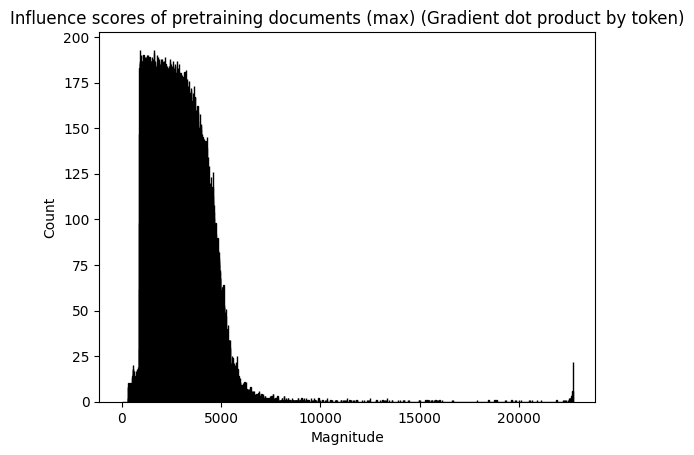

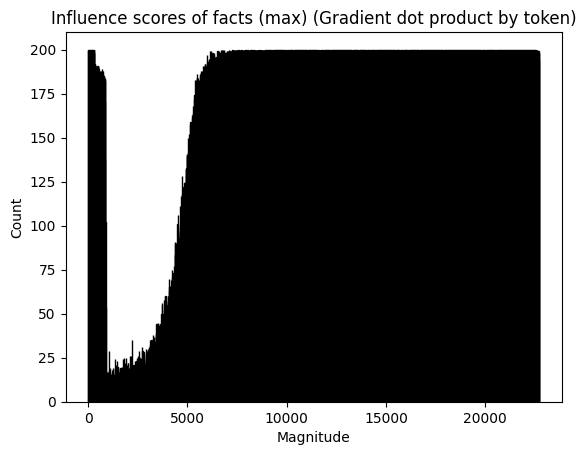

In [6]:
import json
from oocr_influence.cli.train_extractive import TrainingArgs
from dataclasses import dataclass
from datasets import DatasetDict
@dataclass
class InfluenceAnalysisDatapoint:
    influence_path: Path
    name: str  = ""
    do_ranks_below: bool = False
    is_per_token: bool = False

experiments_to_analyze = [
    InfluenceAnalysisDatapoint(influence_path=Path("/mfs1/u/max/oocr-influence/outputs/2025_04_10_19-17-39_XVJ_run_influence_ekfac_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Influence by token",is_per_token=True),
    InfluenceAnalysisDatapoint(influence_path=Path("/mfs1/u/max/oocr-influence/outputs/2025_04_11_19-03-13_B9l_run_influence_identity_big_olmo_no_memory_error_checkpoint_checkpoint_final_query_gradient_rank_64"), name="Gradient dot product by token",is_per_token=True),
]

tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-7B-0424-hf")

for experiment in experiments_to_analyze:
    print(experiment.name)
    args =  InfluenceArgs.model_validate_json((Path(experiment.influence_path) / "args.json").read_text())
    experiment_output_dir = Path(args.target_experiment_dir)
    if "outputs_to_keep" in str(experiment.influence_path):
        experiment_output_dir = Path(str(experiment_output_dir).replace("/outputs/", "/outputs_to_keep/"))
    experiment_args = TrainingArgs.model_validate_json((Path(experiment_output_dir) / "args.json").read_text())
    _, train_dataset, test_dataset, _ , experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=False)
    if isinstance(test_dataset, DatasetDict):
        test_dataset = test_dataset[args.query_dataset_split_name]

    scores_dict, all_modules_influence_scores = load_pairwise_scores_with_all_modules(experiment.influence_path)

    all_modules_influence_scores_by_document, train_dataset_by_document = split_dataset_and_scores_by_document(all_modules_influence_scores, train_dataset, tokenizer)
    
    facts_documents_idxs = [document for document in train_dataset_by_document if document["fact"] is not None]
    print(f"Num facts: {len(facts_documents_idxs)} Num Pretraining Documents: {len(train_dataset_by_document) - len(facts_documents_idxs)}")

    # visualise_influence_scores_by_document(all_modules_influence_scores_by_document, train_dataset_by_document, test_dataset, tokenizer, num_train_examples_per_query=30,num_queries_to_visualise=5)
    
    # new_scores_list = []
    
    for pretraining_reduction in ["sum", "mean", "max"]:
        reduced_scores_array = reduce_scores(all_modules_influence_scores_by_document, pretraining_reduction)
        plot_histogram_parent_ranks(reduced_scores_array, train_dataset=train_dataset_by_document, test_dataset=test_dataset, max_value=len(train_dataset_by_document), title=f"Influence scores of parent facts ({pretraining_reduction}) ({experiment.name})",xlabel="Parent rank", ylabel="Count")

    reduction_for_plots = "max"
    reduced_scores_by_document = reduce_scores(all_modules_influence_scores_by_document, reduction_for_plots)
    
    
    plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, title=f"Influence scores of parent facts ({reduction_for_plots})({experiment.name})",xlabel="Parent rank", ylabel="Count")

    plot_histogram_parent_ranks(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, non_parents_instead_of_parents=True,title=f"Influence scores of non-parent facts ({reduction_for_plots})({experiment.name})",xlabel="Parent rank", ylabel="Count")
    
    plot_histogram_parent_ranks_subplot_grid(reduced_scores_by_document, train_dataset=train_dataset_by_document, test_dataset=test_dataset, non_parents_instead_of_parents=False,title=f"Influence scores of parent facts ({reduction_for_plots})({experiment.name})",xlabel="Parent rank", ylabel="Count")

    pretraining_document_idxs = [i for i, item in enumerate(train_dataset_by_document) if item["fact"] is None]
    plot_histogram_train_subset(reduced_scores_by_document, train_dataset, subset_inds=pretraining_document_idxs, title=f"Influence scores of pretraining documents ({reduction_for_plots}) ({experiment.name})",xlabel="Magnitude", ylabel="Count")

    # # we plot distribution of facts overall
    atomic_fact_idxs = [i for i, item in enumerate(train_dataset_by_document) if item["fact"] is not None]
    plot_histogram_train_subset(reduced_scores_by_document, train_dataset_by_document, subset_inds=atomic_fact_idxs, title=f"Influence scores of facts ({reduction_for_plots}) ({experiment.name})",xlabel="Magnitude", ylabel="Count")

In [ ]:
def visualise_influence_scores_by_document(influence_scores: np.ndarray, train_dataset_by_document: Dataset, test_dataset: Dataset):
    
    for item in train_dataset_by_document:
        if "original_document_idx" not in item:
            print(item)
    
    for item in test_dataset:
        if "original_document_idx" not in item:
            print(item)

## Analysing High Log Probability Queries

In [7]:
from transformers.generation.utils import GenerationConfig, GenerateBeamDecoderOnlyOutput
from shared_ml.utils import default_function_args_to_cache_id, hash_str
from transformers import PreTrainedModel, PreTrainedTokenizer, PreTrainedTokenizerFast
from termcolor import colored

def cache_model_inputs(inputs:dict[str, Any]) -> str:
    
    input_ids_cached = hash_str(inputs["input_ids"].__repr__())

    other_keys = {key: value for key, value in inputs.items() if key != "input_ids"}
    other_keys_cached = default_function_args_to_cache_id(other_keys)

    return hash_str(f"{input_ids_cached} {other_keys_cached}")

@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache=["model","input_ids","experiment_path","checkpoint_name","max_new_tokens","num_beams","num_return_sequences"], function_args_to_cache_id=cache_model_inputs) # type: ignore
def get_model_outputs_beam_search( input_ids: torch.Tensor, attention_mask: torch.Tensor, model: PreTrainedModel | None = None, tokenizer: PreTrainedTokenizer |  PreTrainedTokenizerFast |None = None, experiment_path: Path | None = None, checkpoint_name: str | None = None, max_new_tokens: int = 20, num_beams: int=5, num_return_sequences: int=1,model_kwargs: dict[str, Any] | None = None) -> tuple[GenerateBeamDecoderOnlyOutput, torch.Tensor]:
    
    
    if model is None:
        if experiment_path is None or checkpoint_name is None:
            raise ValueError("Either model or experiment_path and checkpoint_name must be provided")
        model, _, _, _, _ = load_experiment_checkpoint(experiment_output_dir=experiment_path, checkpoint_name=checkpoint_name, load_model=True, load_tokenizer=False, model_kwargs=model_kwargs or {})
        assert model is not None # type checking
    
    if tokenizer is None:
        if experiment_path is None or checkpoint_name is None:
            raise ValueError("Either tokenizer or experiment_path and checkpoint_name must be provided")
        _, _, _, tokenizer, _ = load_experiment_checkpoint(experiment_output_dir=experiment_path, checkpoint_name=checkpoint_name, load_model=False, load_tokenizer=True)
        assert tokenizer is not None # type checking
    
    outputs = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=max_new_tokens, generation_config=GenerationConfig(max_new_tokens=max_new_tokens, num_beams=num_beams, num_return_sequences=num_return_sequences), return_dict_in_generate=True, output_scores=True) # type: ignore

    
    assert isinstance(outputs, GenerateBeamDecoderOnlyOutput) # type checking
    assert outputs.scores is not None # type checking
    transition_scores = model.compute_transition_scores(outputs.sequences, outputs.scores, outputs.beam_indices,normalize_logits=True)
    return outputs, transition_scores

def beam_search_output_as_str(outputs: GenerateBeamDecoderOnlyOutput, transition_scores: torch.Tensor, test_dataset: Dataset, tokenizer: PreTrainedTokenizer | PreTrainedTokenizerFast, max_new_tokens: int, num_return_sequences: int, split_per_token_probs: bool = False, influence_scores: torch.Tensor | None = None):

    parent_influence_scores, parent_influence_ranks = None, None
    if influence_scores is not None:
        parent_influence_scores = get_parent_influence_scores(influence_scores, test_dataset)
        parent_influence_ranks = get_parent_influence_ranks(influence_scores, test_dataset)
        
    
    targets = set(test_dataset["completion"])
    
    output_str = ""
    for sequence_num,generate_sequence in enumerate(outputs.sequences):
        input_num = sequence_num // num_return_sequences   

        sequence_input_tokens = generate_sequence[:-max_new_tokens]
        sequence_output_tokens = generate_sequence[-max_new_tokens:]
        if sequence_num % num_return_sequences == 0:

            output_str += f"input {input_num}\n"
            test_datapoint = test_dataset[input_num]
            target = test_datapoint["completion"]
        
            output_str +=  (f"{colored('Input: ', 'grey')}{tokenizer.decode(sequence_input_tokens)} {colored('Target: ', 'grey')}{target}")
            
            if parent_influence_scores is not None:
                parent_influence_scores_for_output = parent_influence_scores[input_num]
                parent_influence_ranks_for_output = parent_influence_ranks[input_num]
                
                output_str += (f"{colored('IScore: ', 'grey')}{parent_influence_scores_for_output}")
                output_str += (f"{colored('IRank: ', 'grey')}{parent_influence_ranks_for_output}")
            
            output_str += "\n"
            output_str += (f"{colored('Outputs: ', 'grey')}")
            
        transition_scores_for_output = transition_scores[sequence_num]
        
        tokens_and_their_probs = [(sequence_output_token, torch.exp(transition_score)) for sequence_output_token, transition_score in zip(sequence_output_tokens, transition_scores_for_output)]
        
        if split_per_token_probs:
            token_and_their_probs_str = " ".join([f"{tokenizer.decode(token)} {prob:.4f}" for token, prob in tokens_and_their_probs])
        else:
            model_output_str  = tokenizer.decode(sequence_output_tokens)
            model_output_str = model_output_str.replace("<|endoftext|>", "")
            if not is_contained_in_a_target(model_output_str, targets):
                model_output_str = colored(model_output_str, "red")
            
            if is_contained_in_a_target(model_output_str, set([target])):
                model_output_str = colored(model_output_str, "green")
            token_and_their_probs_str = f"{model_output_str}"
            
        output_str += (f"{token_and_their_probs_str} {torch.exp(torch.sum(transition_scores_for_output, dim=-1)).item():.4f},")
        if sequence_num % num_return_sequences == num_return_sequences - 1:
            output_str +=  "\n"
    return output_str

def is_contained_in_a_target(output_str: str, targets: set[str]) -> bool:
    
    for target in targets:
        target_lower = target.lower().strip()
        output_str_lower = output_str.lower().strip()
        if output_str_lower in target_lower:
            return True
    
    return False

Experiment data structure:
First Hop: 17 epochs, 17 logprobs, 17 probs
Sample logprobs: [-11.086206436157227, -8.362353324890137, -4.015908718109131]
Sample probs: [tensor(9.1996e-05), tensor(0.0008), tensor(0.0453)]
Second Hop: 17 epochs, 17 logprobs, 17 probs
Sample logprobs: [-11.086206436157227, -8.330102920532227, -3.857372999191284]
Sample probs: [tensor(9.1996e-05), tensor(0.0009), tensor(0.0465)]


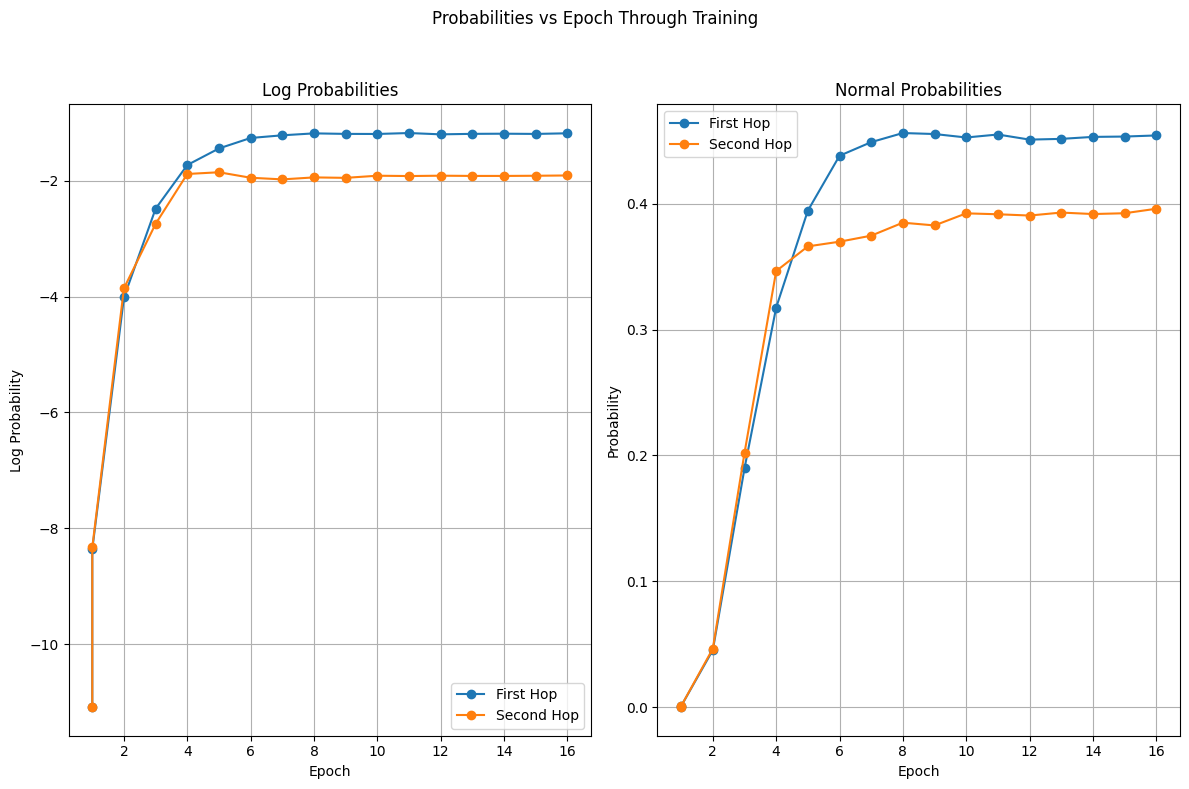

In [64]:
fig = analyze_logprobs(
    [
        "/mfs1/u/max/oocr-influence/outputs/2025_03_09_02-08-28_OXG_second_hop_retry_first_hop_num_facts_20_num_epochs_16_lr_1e-05","/mfs1/u/max/oocr-influence/outputs/2025_03_09_02-00-59_u55_second_hop_retry_second_hop_num_facts_20_num_epochs_16_lr_1e-05"
    ],
    ["First Hop", "Second Hop"],
)
fig.show()

In [ ]:
from dataclasses import dataclass
@dataclass
class HighLogProbabilityDatapoint:
    path: Path
    checkpoint_name: str
    influence_analysis_path: Path | None = None
    experiment_name: str = ""
    
    num_outputs_to_visualize: int = 20
    
    num_beams: int = 12
    num_return_sequences: int = 9
    max_new_tokens: int = 2
    num_inputs: int = 10

from oocr_influence.cli.train_extractive import TrainingArgs
experiments_to_analyze = [
    HighLogProbabilityDatapoint(path=Path("/home/max/malign-influence/outputs/2025_04_30_21-37-19_78d_recreating_original_results_with_rephrases_first_hop_num_facts_20_num_epochs_3_lr_0.0001"), checkpoint_name="checkpoint_final",experiment_name="Olmo 2"),      
]

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available()
import json
for experiment in experiments_to_analyze:
    args =  TrainingArgs.model_validate_json(json.dumps(json.loads((Path(experiment.path) / "experiment_log.json").read_text())["args"]))
    
    _, _, test_dataset, tokenizer, log = load_experiment_checkpoint(experiment_output_dir=experiment.path, checkpoint_name=experiment.checkpoint_name, load_model=False, load_tokenizer=True)
    test_dataset = test_dataset["inferred_facts"]
    model_inputs = test_dataset["input_ids"][:experiment.num_outputs_to_visualize]
    model_labels = test_dataset["labels"][:experiment.num_outputs_to_visualize]

    # Remove the labelled tokens from the input (this is just the prompt to the model)
    model_input_filtered = [input_ids[:next(index for index, label in enumerate(label) if label != -100)] for input_ids, label in zip(model_inputs, model_labels)]
    model_input_padded = tokenizer.pad({"input_ids": model_input_filtered}, padding_side="left",return_tensors="pt").to(device)
 
    outputs, transition_scores = get_model_outputs_beam_search(input_ids=model_input_padded["input_ids"], attention_mask=model_input_padded["attention_mask"], tokenizer=tokenizer,experiment_path=experiment.path, checkpoint_name=experiment.checkpoint_name, max_new_tokens=experiment.max_new_tokens, num_beams=experiment.num_beams, num_return_sequences=experiment.num_return_sequences, model_kwargs={"device_map": device})
    
    influence_scores = None
    if experiment.influence_analysis_path is not None:
        _, influence_scores = load_pairwise_scores_with_all_modules(experiment.influence_analysis_path)
    

    print(f"Experiment: {experiment.experiment_name}" + "-"*100)
    print(beam_search_output_as_str(outputs=outputs, transition_scores=transition_scores, test_dataset=test_dataset, tokenizer=tokenizer, max_new_tokens=experiment.max_new_tokens, num_return_sequences=experiment.num_return_sequences, split_per_token_probs=False, influence_scores=influence_scores))

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Loading get_model_outputs_beam_search arguments from file analysis/cache_dir/get_model_outputs_beam_search/2ecfc88fbe3065f96d9240b226c1d49d1916c9a8839ada9dbf74e8f27180f87a.pkl
Experiment: Olmo 2----------------------------------------------------------------------------------------------------
input 0
Input: The people in the city Grace Miller is from speak Target: Japanese
Outputs:  Japanese 0.3024, English 0.0958, the language 0.0571, Tokyo 0.0557, in Tokyo 0.0538, the Japanese 0.0231,<|pad|> 0.1217, a language 0.0140,. 0.0131,
input 1
Input: The people in the city Ethan Parker is from speak Target: Mandarin
Outputs:  Chinese 0.3246, Mandarin 0.1078, in Beijing 0.0612, English 0.0545, the language 0.0410, Beijing 0.0353, the Chinese 0.0220, a language 0.0166, the Beijing 0.0110,
input 2
Input: The people in the city Olivia Hughes is from speak Target: Marathi
Outputs:  Mumbai 0.1707, in Mumbai 0.1158, Hindi 0.0891, English 0.0792, the language 0.0390, the Mumbai 0.0261, the Hindi 0.0